In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## NLP project

In this project, we implement and compare three popular models for sentiment analysis: a Fully Connected Neural Network (FCNN), a Recurrent Neural Network (RNN) with LSTM, and the state-of-the-art BERT transformer. We analyze their performance on a labeled emotion dataset.

In [2]:
import pandas as pd

train_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/NLP_project/NLP_exam_emotions_dataset/train.txt', sep=';', names=['text', 'label'])
test_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/NLP_project/NLP_exam_emotions_dataset/test.txt', sep=';', names=['text', 'label'])

print("Training Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())


Training Data:
                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

Test Data:
                                                text    label
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness


### Checking missing values

In [3]:
print("Missing values in training data:\n", train_data.isnull().sum())
print("\nMissing values in test data:\n", test_data.isnull().sum())

print("\nTraining data label distribution:\n", train_data['label'].value_counts())
print("\nTest data label distribution:\n", test_data['label'].value_counts())


Missing values in training data:
 text     0
label    0
dtype: int64

Missing values in test data:
 text     0
label    0
dtype: int64

Training data label distribution:
 label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

Test data label distribution:
 label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


### Data preprocessing

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower().strip()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['cleaned_text'])
vocab_size = len(tokenizer.word_index) + 1

max_length = 100
train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_data['cleaned_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Converts labels to integers
label_mapping = {label: idx for idx, label in enumerate(train_data['label'].unique())}
train_labels = train_data['label'].map(label_mapping).values
test_labels = test_data['label'].map(label_mapping).values


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Model Training
Now, we can proceed with training the models. We'll start with a Fully Connected Neural Network (FCNN).

1. Fully Connected Neural Network (FCNN)

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout

embedding_dim = 100

# FCNN model
model_fcnn = Sequential()
model_fcnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_fcnn.add(Flatten())
model_fcnn.add(Dense(64, activation='relu'))
model_fcnn.add(Dropout(0.5))
model_fcnn.add(Dense(len(label_mapping), activation='softmax'))

# Compile
model_fcnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history_fcnn = model_fcnn.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate
loss, accuracy = model_fcnn.evaluate(test_padded, test_labels, verbose=2)
print(f"FCNN Test Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
400/400 - 7s - 17ms/step - accuracy: 0.3718 - loss: 1.5052 - val_accuracy: 0.5650 - val_loss: 1.0938
Epoch 2/10
400/400 - 3s - 6ms/step - accuracy: 0.7552 - loss: 0.6984 - val_accuracy: 0.8628 - val_loss: 0.4633
Epoch 3/10
400/400 - 3s - 7ms/step - accuracy: 0.9397 - loss: 0.2179 - val_accuracy: 0.8772 - val_loss: 0.3970
Epoch 4/10
400/400 - 5s - 12ms/step - accuracy: 0.9731 - loss: 0.0978 - val_accuracy: 0.8703 - val_loss: 0.4355
Epoch 5/10
400/400 - 2s - 6ms/step - accuracy: 0.9852 - loss: 0.0598 - val_accuracy: 0.8747 - val_loss: 0.4493
Epoch 6/10
400/400 - 4s - 9ms/step - accuracy: 0.9880 - loss: 0.0460 - val_accuracy: 0.8759 - val_loss: 0.5022
Epoch 7/10
400/400 - 3s - 7ms/step - accuracy: 0.9908 - loss: 0.0348 - val_accuracy: 0.8753 - val_loss: 0.5225
Epoch 8/10
400/400 - 1s - 3ms/step - accuracy: 0.9930 - loss: 0.0252 - val_accuracy: 0.8731 - val_loss: 0.5793
Epoch 9/10
400/400 - 2s - 4ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.8728 - val_loss: 0.5799

2. Recurrent Neural Network (RNN) with LSTM

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# Hyperparameters
embedding_dim = 128
lstm_units = 128
dropout_rate = 0.5
learning_rate = 1e-3
batch_size = 32
epochs = 10
max_length = 100  # Ensure this matches the max_length used in your tokenization

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
vocab_size = len(tokenizer.word_index) + 1

train_sequences = tokenizer.texts_to_sequences(train_data['text'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Model architecture
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units)),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(len(label_mapping), activation='softmax')
])

# Compile model
optimizer = Adam(learning_rate=learning_rate)
model_rnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Convert labels to integers
train_labels = train_data['label'].map(label_mapping).values
test_labels = test_data['label'].map(label_mapping).values

# Train model
history_rnn = model_rnn.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                            validation_split=0.2, verbose=2)

# Evaluate model
loss, accuracy = model_rnn.evaluate(test_padded, test_labels, verbose=2)
print(f"RNN Model Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10
400/400 - 18s - 45ms/step - accuracy: 0.4985 - loss: 1.2889 - val_accuracy: 0.7297 - val_loss: 0.7192
Epoch 2/10
400/400 - 17s - 41ms/step - accuracy: 0.8078 - loss: 0.5446 - val_accuracy: 0.8844 - val_loss: 0.3659
Epoch 3/10
400/400 - 12s - 30ms/step - accuracy: 0.9160 - loss: 0.2667 - val_accuracy: 0.9097 - val_loss: 0.2708
Epoch 4/10
400/400 - 17s - 42ms/step - accuracy: 0.9374 - loss: 0.2024 - val_accuracy: 0.9169 - val_loss: 0.2847
Epoch 5/10
400/400 - 9s - 23ms/step - accuracy: 0.9584 - loss: 0.1318 - val_accuracy: 0.9219 - val_loss: 0.3117
Epoch 6/10
400/400 - 10s - 24ms/step - accuracy: 0.9665 - loss: 0.1084 - val_accuracy: 0.9156 - val_loss: 0.3171
Epoch 7/10
400/400 - 10s - 26ms/step - accuracy: 0.9727 - loss: 0.0883 - val_accuracy: 0.9209 - val_loss: 0.3162
Epoch 8/10
400/400 - 10s - 26ms/step - accuracy: 0.9786 - loss: 0.0672 - val_accuracy: 0.9156 - val_loss: 0.3326
Epoch 9/10
400/400 - 11s - 27ms/step - accuracy: 0.9837 - loss: 0.0570 - val_accuracy: 0.9194 - v

3. Transformer-Based Model.
- Fine-tune a pre-trained Transformer model using HuggingFace's transformers library

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer

# Model & Tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

# Encoding Function
def encode_texts(texts, tokenizer, max_length):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=max_length)

# Encoding Data
train_encodings = encode_texts(train_data['text'].tolist(), tokenizer, max_length=max_length)
test_encodings = encode_texts(test_data['text'].tolist(), tokenizer, max_length=max_length)


# Convert Labels to Tensors
y_train_tensor = tf.constant(train_labels)

y_test_tensor = tf.constant(test_labels)

# Optimizer
num_train_steps = len(train_encodings['input_ids']) // 16 * 10
optimizer, lr_schedule = create_optimizer(init_lr=5e-5, num_train_steps=num_train_steps, num_warmup_steps=0)

# Compile
transformer_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

# Train
history = transformer_model.fit(train_encodings['input_ids'], y_train_tensor, epochs=10, batch_size=32,
                                validation_data=(test_encodings['input_ids'], y_test_tensor))

# Evaluate
loss, accuracy = transformer_model.evaluate(test_encodings['input_ids'], y_test_tensor)
print(f"Transformer Model Test Accuracy: {accuracy:.4f}")


### Model Comparison and Analysis
We compared the performance of the models based on accuracy and other relevant metrics.

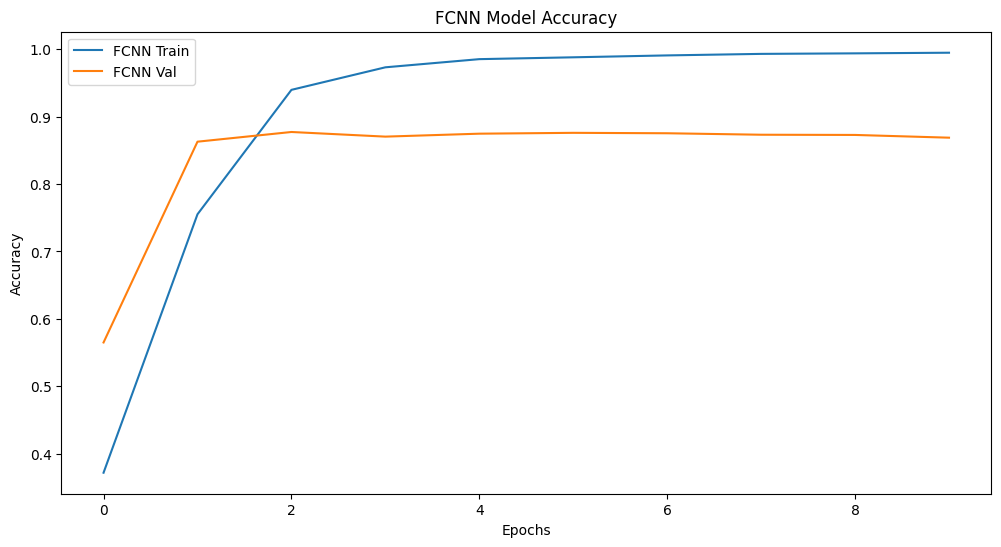

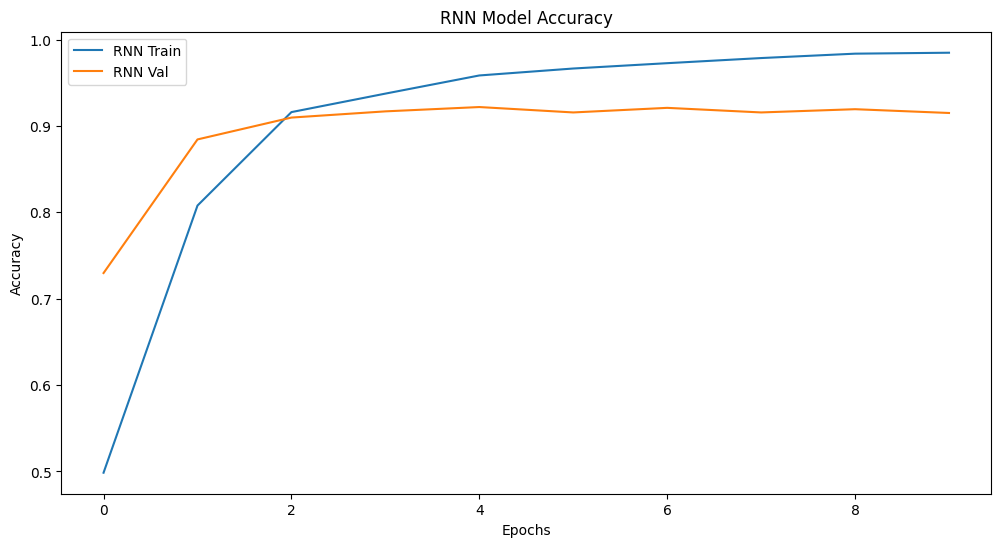

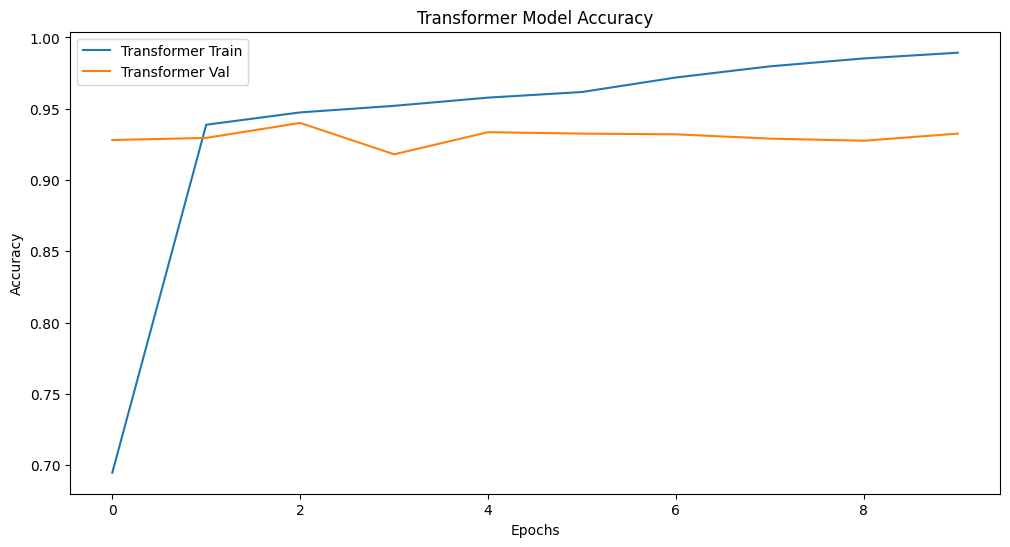

In [11]:
# Plot for FCNN
plt.figure(figsize=(12, 6))
plt.plot(history_fcnn.history['accuracy'], label='FCNN Train')
plt.plot(history_fcnn.history['val_accuracy'], label='FCNN Val')
plt.title('FCNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot for RNN
plt.figure(figsize=(12, 6))
plt.plot(history_rnn.history['accuracy'], label='RNN Train')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val')
plt.title('RNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot for Transformer
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Transformer Train')
plt.plot(history.history['val_accuracy'], label='Transformer Val')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Validation and Final Performance Check

In [17]:
from transformers import BertTokenizerFast, TFBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [18]:
# Load validation data
validation_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/NLP_project/NLP_exam_emotions_dataset/validation.txt', sep=';', names=['text', 'label'])

In [19]:
# Preprocess validation data using BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
validation_encodings = tokenizer(validation_data['text'].tolist(), truncation=True, padding=True, max_length=100)

# Convert validation labels to integers
validation_labels = validation_data['label'].map(label_mapping).values

# Create TensorFlow dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(validation_encodings),
    validation_labels
)).batch(32)


In [20]:
# Define Keras Tokenizer for FCNN and RNN
keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(train_data['cleaned_text'])

# Preprocess validation data for FCNN and RNN models
validation_data['cleaned_text'] = validation_data['text'].apply(clean_text)
validation_sequences = keras_tokenizer.texts_to_sequences(validation_data['cleaned_text'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post')
validation_labels = validation_data['label'].map(label_mapping).values

# Define BERT Tokenizer for BERT model
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def bert_tokenize(texts, max_len=100):
    return bert_tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_len, return_tensors='tf')

# Preprocess validation data for BERT model
validation_tokens_bert = bert_tokenize(validation_data['text'])
X_val_bert = validation_tokens_bert['input_ids']
attention_mask_val_bert = validation_tokens_bert['attention_mask']
y_val_bert = validation_data['label'].map(label_mapping).values


63/63 - 0s - 3ms/step - accuracy: 0.8700 - loss: 0.6195
FCNN Validation Accuracy: 87.00%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCNN Validation Classification Report:
              precision    recall  f1-score   support

     sadness       0.91      0.91      0.91       550
       anger       0.87      0.83      0.85       275
        love       0.85      0.68      0.75       178
    surprise       0.83      0.74      0.78        81
        fear       0.82      0.81      0.82       212
         joy       0.86      0.94      0.90       704

    accuracy                           0.87      2000
   macro avg       0.86      0.82      0.84      2000
weighted avg       0.87      0.87      0.87      2000



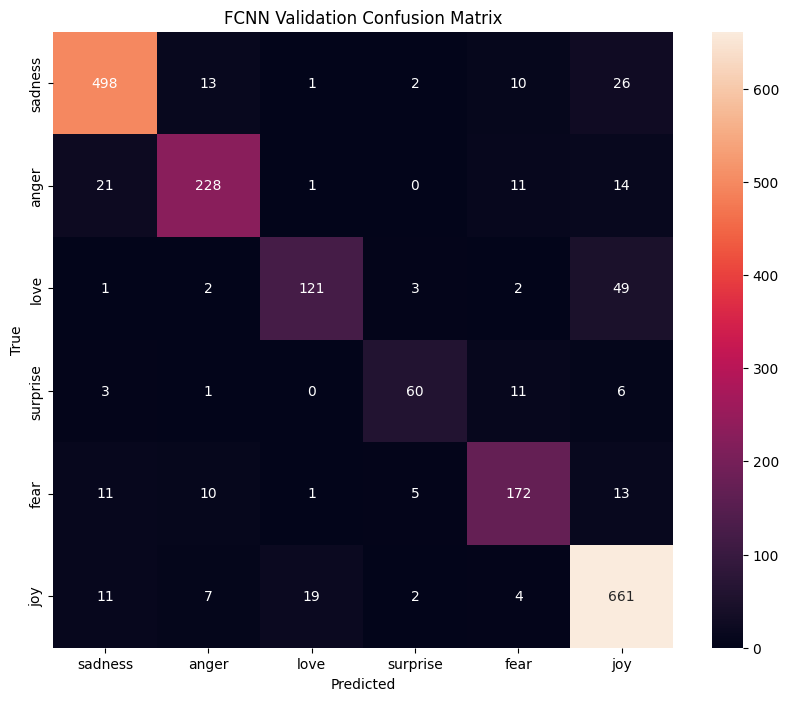

In [21]:
# Evaluate FCNN on validation data
validation_loss_fcnn, validation_accuracy_fcnn = model_fcnn.evaluate(validation_padded, validation_labels, verbose=2)
print(f"FCNN Validation Accuracy: {validation_accuracy_fcnn * 100:.2f}%")

# Predictions on validation data
validation_predictions_fcnn = model_fcnn.predict(validation_padded)
validation_predicted_labels_fcnn = np.argmax(validation_predictions_fcnn, axis=1)

# Classification Report for validation data
print("FCNN Validation Classification Report:")
print(classification_report(validation_labels, validation_predicted_labels_fcnn, target_names=label_mapping.keys()))

# Confusion Matrix for validation data
validation_conf_matrix_fcnn = confusion_matrix(validation_labels, validation_predicted_labels_fcnn)
plt.figure(figsize=(10, 8))
sns.heatmap(validation_conf_matrix_fcnn, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('FCNN Validation Confusion Matrix')
plt.show()

63/63 - 1s - 11ms/step - accuracy: 0.2175 - loss: 6.7162
RNN Validation Accuracy: 21.75%
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RNN Validation Classification Report:
              precision    recall  f1-score   support

     sadness       0.22      0.17      0.19       550
       anger       0.13      0.17      0.15       275
        love       0.10      0.08      0.09       178
    surprise       0.05      0.05      0.05        81
        fear       0.09      0.09      0.09       212
         joy       0.34      0.37      0.35       704

    accuracy                           0.22      2000
   macro avg       0.15      0.15      0.15      2000
weighted avg       0.22      0.22      0.22      2000



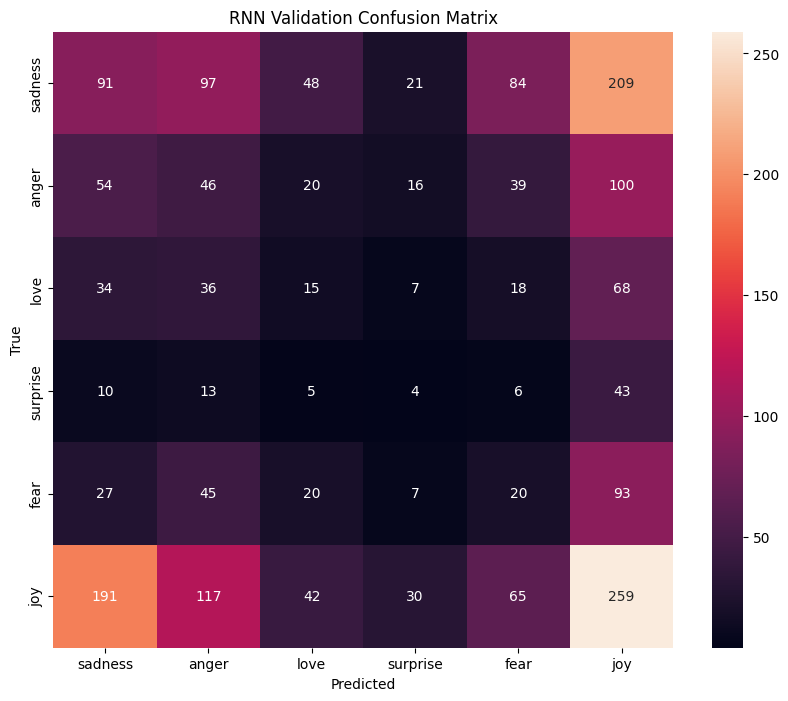

In [22]:
# Evaluate RNN on validation data
validation_loss_rnn, validation_accuracy_rnn = model_rnn.evaluate(validation_padded, validation_labels, verbose=2)
print(f"RNN Validation Accuracy: {validation_accuracy_rnn * 100:.2f}%")

# Predictions on validation data
validation_predictions_rnn = model_rnn.predict(validation_padded)
validation_predicted_labels_rnn = np.argmax(validation_predictions_rnn, axis=1)

# Classification Report for validation data
print("RNN Validation Classification Report:")
print(classification_report(validation_labels, validation_predicted_labels_rnn, target_names=label_mapping.keys()))

# Confusion Matrix for validation data
validation_conf_matrix_rnn = confusion_matrix(validation_labels, validation_predicted_labels_rnn)
plt.figure(figsize=(10, 8))
sns.heatmap(validation_conf_matrix_rnn, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RNN Validation Confusion Matrix')
plt.show()

63/63 [==============================] - 18s 233ms/step - loss: 0.1995 - accuracy: 0.9405
BERT Validation Accuracy: 94.05%
63/63 [==============================] - 18s 218ms/step
BERT Validation Classification Report:
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       550
       anger       0.94      0.94      0.94       275
        love       0.87      0.87      0.87       178
    surprise       0.79      0.95      0.87        81
        fear       0.93      0.91      0.92       212
         joy       0.96      0.95      0.95       704

    accuracy                           0.94      2000
   macro avg       0.91      0.93      0.92      2000
weighted avg       0.94      0.94      0.94      2000



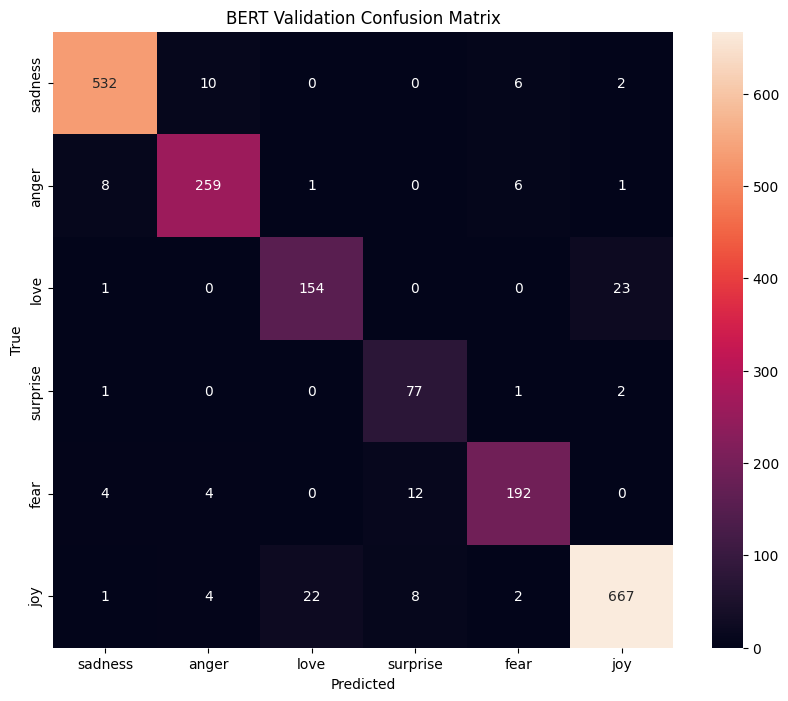

In [23]:
# Evaluate BERT on validation data
validation_loss_bert, validation_accuracy_bert = transformer_model.evaluate(
    {'input_ids': X_val_bert, 'attention_mask': attention_mask_val_bert},
    y_val_bert
)
print(f"BERT Validation Accuracy: {validation_accuracy_bert * 100:.2f}%")

# Predictions on validation data
validation_predictions_bert = transformer_model.predict({'input_ids': X_val_bert, 'attention_mask': attention_mask_val_bert}).logits
validation_predicted_labels_bert = np.argmax(validation_predictions_bert, axis=1)

# Classification Report for validation data
print("BERT Validation Classification Report:")
print(classification_report(y_val_bert, validation_predicted_labels_bert, target_names=label_mapping.keys()))

# Confusion Matrix for validation data
validation_conf_matrix_bert = confusion_matrix(y_val_bert, validation_predicted_labels_bert)
plt.figure(figsize=(10, 8))
sns.heatmap(validation_conf_matrix_bert, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Validation Confusion Matrix')
plt.show()

In [ ]:
import nbformat

with open("NLP_final_project.ipynb") as f:
    nb = nbformat.read(f, as_version=4)

nb.metadata.pop("widgets", None)  # remove corrupted widgets metadata

with open("NLP_final_project.ipynb", "w") as f:
    nbformat.write(nb, f)

### Conclusion:

According to the validation accuracy and the confusion matrix above, we can see that the accuracy score for FCNN is 87.0%, RNN is 21.75%, and BERT is the highest: 94.05%. Hence, BERT model is the best approach.

However, the result of RNN is negative, we can see from the Confusion Matrix, the model only predicted the emotion "joy" successfully.